In [5]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

shap.initjs()
%matplotlib inline

np.random.seed(3)

In [7]:
all_GATGT=pd.read_csv('/home/jiayi/5moU/data/DL_fromTombo/all_GATGT.csv')
all_GATGT

,indx,kmer,mean_1,mean_2,mean_3,mean_4,mean_5,std_1,std_2,std_3,...,mdintense_2,mdintense_3,mdintense_4,mdintense_5,L-1,L-2,L-3,L-4,L-5,label
0,792,GATGT,0.695437,-0.469584,-0.244677,0.166784,-0.619996,0.326583,0.051584,0.092517,...,-0.475494,-0.236700,0.211564,-0.617933,22,168,146,45,65,1
1,252,GATGT,0.512255,-0.305857,0.022603,0.017033,-0.432095,0.367382,0.071119,0.188586,...,-0.314251,-0.034491,-0.042156,-0.434969,6,478,98,9,36,1
2,163,GATGT,0.512871,-0.497382,-0.205308,0.097433,-0.605112,0.101281,0.104327,0.097148,...,-0.502096,-0.200407,0.094816,-0.609842,2,32,219,28,123,1
3,454,GATGT,0.382485,-0.432326,-0.132161,0.587094,-0.370832,0.383626,0.064145,0.087635,...,-0.427725,-0.143946,0.647757,-0.403049,6,59,52,12,6,1
4,393,GATGT,0.640104,-0.361050,-0.388824,-0.329214,-0.513442,0.194791,0.083004,0.054929,...,-0.370969,-0.404694,-0.357083,-0.509835,12,6,18,414,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5788,97,GATGT,0.960401,-0.562450,-0.221959,0.752635,-0.488234,0.192127,0.116180,0.116252,...,-0.577020,-0.230028,0.775858,-0.497095,12,852,43,23,22,0
5789,772,GATGT,0.428535,-0.819756,-0.415518,0.242478,-0.799007,0.124649,0.090871,0.100001,...,-0.821610,-0.398356,0.262553,-0.796713,6,420,91,23,146,0
5790,792,GATGT,0.642941,-0.779994,-0.432435,0.314762,-0.801372,0.468930,0.138998,0.102647,...,-0.796333,-0.413397,0.241511,-0.809388,16,155,32,12,76,0
5791,565,GATGT,0.688542,-0.501493,-0.191662,0.438627,-0.502063,0.267426,0.092075,0.137961,...,-0.511488,-0.185485,0.395326,-0.518982,16,421,37,18,33,0


In [8]:
kfolds = KFold(n_splits=5, shuffle=True)

In [9]:
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.2,
    'silent': 1,
    'nthreads': 2,
}

num_round = 10

thres = 0.5

In [10]:
features = ['mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5',
        'std_1', 'std_2', 'std_3', 'std_4', 'std_5', 'mdintense_1',
        'mdintense_2', 'mdintense_3', 'mdintense_4', 'mdintense_5', 'L-1',
        'L-2', 'L-3', 'L-4', 'L-5']
target = 'label'

#X = dataset[features]
X=all_GATGT.iloc[:,2:all_GATGT.shape[1]-1]
y = all_GATGT[target]

In [11]:
cnf = list()
auc = list()

for train_idx, test_idx in kfolds.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    param['scale_pos_weight'] = (y_train.size - y_train.sum()) / y_train.sum()    
    
    xg_train = xgb.DMatrix(
        X_train.values, feature_names=features, label=y_train.values
    )
    xg_test = xgb.DMatrix(
        X_test.values, feature_names=features, label=y_test.values
    )
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    bst = xgb.train(param, xg_train, num_round, watchlist, verbose_eval=False)
    preds = bst.predict(xg_test)
    
    cnf.append(confusion_matrix(y_test, (preds > thres).astype(int)))
    auc.append(roc_auc_score(y_test, preds))
    
cnf = sum(cnf)
auc = sum(auc) / len(auc)

'Average AUC: {:.04f}'.format(auc)    

Pass `evals` as keyword args.
Pass `evals` as keyword args.


[11:54:30] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[11:54:30] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[11:54:30] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[11:54:30] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[11:54:30] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.



Pass `evals` as keyword args.
Pass `evals` as keyword args.
Pass `evals` as keyword args.


'Average AUC: 0.9899'

Text(58.222222222222214, 0.5, 'Observation')

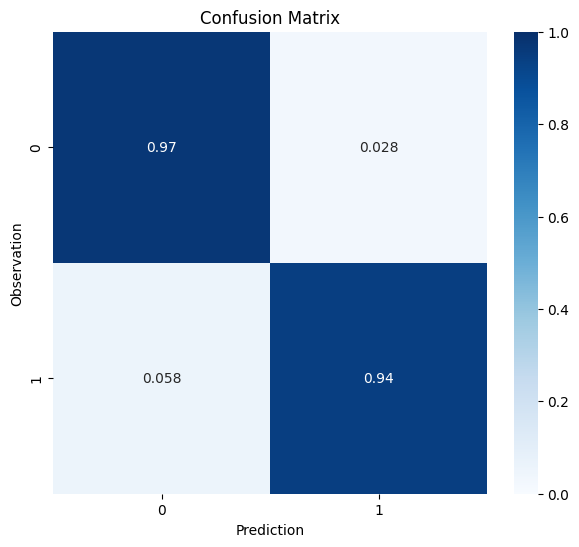

In [12]:
fig, ax = plt.subplots(figsize=(7, 6))

normalized_cnf = cnf / cnf.sum(axis=1).reshape(-1, 1)

sns.heatmap(normalized_cnf, annot=True, cmap="Blues", ax=ax, vmin=0, vmax=1)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation')

In [13]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


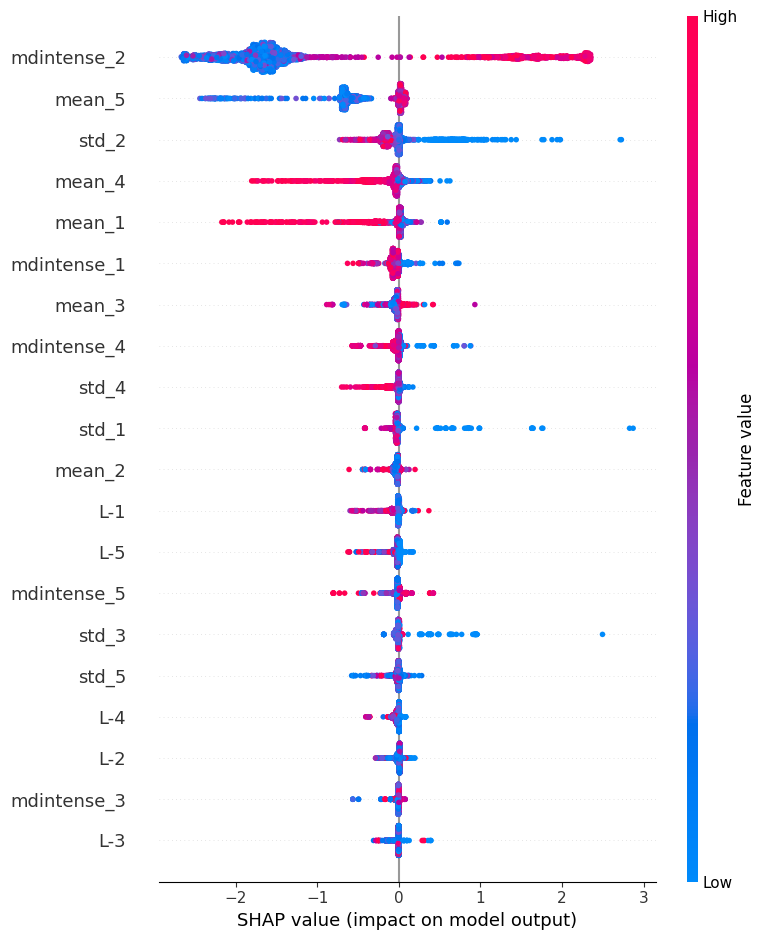

In [14]:
shap.summary_plot(shap_values, X)